# Applied Data Science 2 - Keras Assignment - 2023A


In this assignment you will be building a script to classify movie posters. The assignment is broken up into sections and you need to complete each section successively. The sections are:

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation

In addition to this coding exercise, you will also need to write a 1-2 page report analysing and critically evaluating you models results.

Name: Shubham Verma

Student ID: 22099668

Email ID: sv23abk@herts.ac.uk

In [1]:
# Enter your module imports here, some modules are already provided
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import requests
import seaborn as sns
import zipfile

import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
import matplotlib.patches as mpatches

In [2]:
# CodeGrade Tag Init1
# Do not edit, remove, or copy this cell

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing



In [3]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multi_Label_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multi_Label_dataset/Images /tmp/Multi_Label_dataset/

        190.94M 100%  920.47kB/s    0:03:22 (xfr#7867, to-chk=0/7868)


In [4]:
# CodeGrade Tag DataProc
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multi_Label_dataset/train.csv"
dataset = pd.read_csv("/content/drive/MyDrive/Multi_Label_dataset/train.csv")

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre'],axis=1).columns)

# Build the file locations for the images
img_loc = "/tmp/Multi_Label_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]


# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

# Create the initial datasets
train_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
test_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [5]:
# CodeGrade Tag Ex1a
### Write a function called img_process, which takes in the image and label as
### inputs, converts the data type of the image to tf.float32, resizes the
### image to (64, 64), and finally returns the image and labels.
def img_process(image, label):
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)

    # Resize image to (64, 64)
    image = tf.image.resize(image, (64, 64))

    return image, label


**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [6]:
# CodeGrade Tag Ex1b
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64. Use techniques like caching and
### prefetching to efficiently load the data.

# Apply img_process function to datasets
train_dataset = train_list_ds.map(parse_image).map(img_process)
test_dataset = test_list_ds.map(parse_image).map(img_process)

# Define batch size
batch_size = 64

# Define the number of parallel calls for map transformation
num_parallel_calls = tf.data.experimental.AUTOTUNE

# Shuffle and batch the training dataset
#train_dataset = train_dataset.shuffle(buffer_size=len(data_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(buffer_size=num_parallel_calls)

# Batch the validation dataset
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.cache()
test_dataset = test_dataset.prefetch(buffer_size=num_parallel_calls)


# Model Definition

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [7]:
# CodeGrade Tag Ex2a
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.
# Define input layer
inputs = layers.Input(shape=(64, 64, 3), name='Input')

# Convolutional layers
conv0 = layers.Conv2D(16, (3, 3), activation='relu', name='Conv0')(inputs)
drop1 = layers.Dropout(0.2, name='Drop1')(conv0)

conv1 = layers.Conv2D(32, (3, 3), activation='relu', name='Conv1')(drop1)
conv2 = layers.Conv2D(32, (3, 3), activation='relu', name='Conv2')(conv1)
drop2 = layers.Dropout(0.2, name='Drop2')(conv2)
pool1 = layers.MaxPooling2D((2, 2), name='Pool1')(drop2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu', name='Conv3')(pool1)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', name='Conv4')(conv3)
drop3 = layers.Dropout(0.2, name='Drop3')(conv4)
pool2 = layers.MaxPooling2D((2, 2), name='Pool2')(drop3)

conv5 = layers.Conv2D(128, (3, 3), activation='relu', name='Conv5')(pool2)
conv6 = layers.Conv2D(128, (3, 3), activation='relu', name='Conv6')(conv5)
drop4 = layers.Dropout(0.2, name='Drop4')(conv6)
pool3 = layers.MaxPooling2D((2, 2), name='Pool3')(drop4)

# Flatten layer
flat = layers.Flatten(name='Flat')(pool3)

# Dense layers
fc1 = layers.Dense(1024, activation='relu', name='FC1')(flat)
drop5 = layers.Dropout(0.5, name='Drop5')(fc1)

fc2 = layers.Dense(1024, activation='relu', name='FC2')(drop5)
drop6 = layers.Dropout(0.5, name='Drop6')(fc2)

# Output layer
output = layers.Dense(25, activation='sigmoid', name='Output')(drop6)

# Define the model
model = Model(inputs=inputs, outputs=output)


In [8]:
# CodeGrade Tag Ex2b
### Print the model summary and confirm is has the same architecture as the one
### provided.

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 62, 62, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 62, 62, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 60, 60, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 58, 58, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 58, 58, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 29, 29, 32)        0     

**Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [9]:
# CodeGrade Tag Ex2c
### Compile the model using the Adam Optimizer, binary crossentropy loss, and
### precision and recall metrics.
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation accuracy.**

In [10]:
# CodeGrade Tag Ex3a
### Create a ModelCheckpoint callback to store the bext weights from the model,
### based on the validation accuracy. Call this callback "checkpoint_callback"
### Update by Ashley, check val losss

checkpoint_filepath = '/content/checkpoint'

# Create ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      mode='min',
                                      save_best_only=True)

**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [11]:
# CodeGrade Tag Ex3b
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

# Create LearningRateScheduler callback
lr_callback = LearningRateScheduler(scheduler)

**Train the model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [12]:
# CodeGrade Tag Ex3c
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.
# Train the model
history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=test_dataset,
                    callbacks=[checkpoint_callback, lr_callback])

# Extract loss and metric values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

Epoch 1/40
91/91 [==============================] - 17s 75ms/step - loss: 0.4689 - accuracy: 0.1849 - precision: 0.2609 - recall: 0.2203 - val_loss: 0.3711 - val_accuracy: 0.2357 - val_precision: 0.5165 - val_recall: 0.1375 - lr: 1.0000e-04
Epoch 2/40
91/91 [==============================] - 3s 35ms/step - loss: 0.2788 - accuracy: 0.2288 - precision: 0.4301 - recall: 0.1833 - val_loss: 0.3682 - val_accuracy: 0.2495 - val_precision: 0.5481 - val_recall: 0.1734 - lr: 1.0000e-04
Epoch 3/40
91/91 [==============================] - 3s 36ms/step - loss: 0.2679 - accuracy: 0.2413 - precision: 0.4694 - recall: 0.1810 - val_loss: 0.3614 - val_accuracy: 0.2757 - val_precision: 0.5507 - val_recall: 0.1430 - lr: 1.0000e-04
Epoch 4/40
91/91 [==============================] - 3s 30ms/step - loss: 0.2614 - accuracy: 0.2485 - precision: 0.4774 - recall: 0.1854 - val_loss: 0.3614 - val_accuracy: 0.2612 - val_precision: 0.5854 - val_recall: 0.1053 - lr: 1.0000e-04
Epoch 5/40
91/91 [=====================

# Model Evaluation

**Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the models performance.**

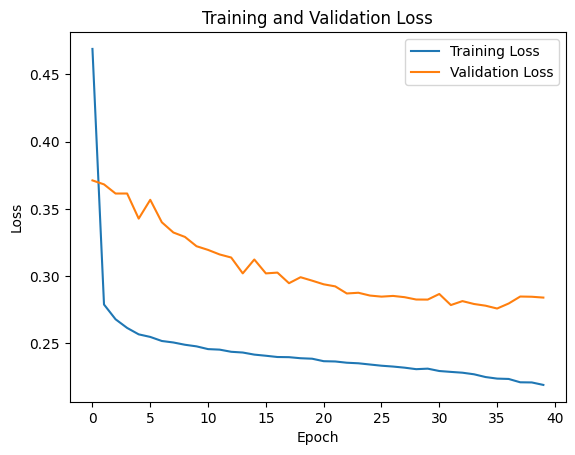

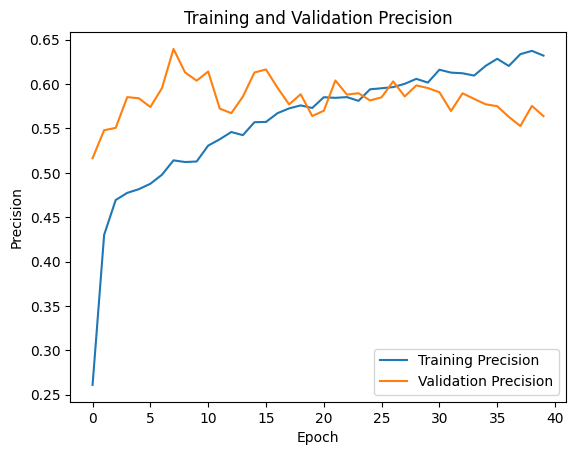

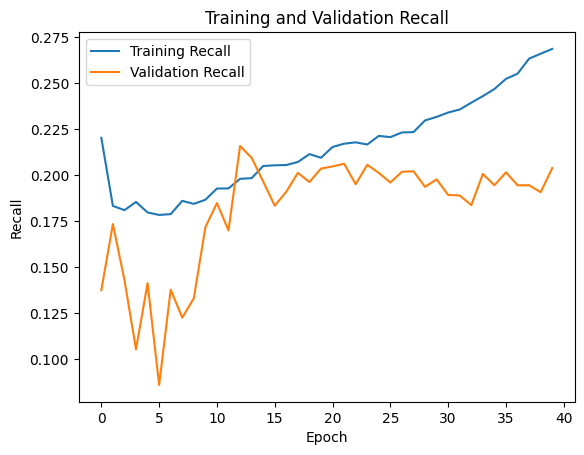

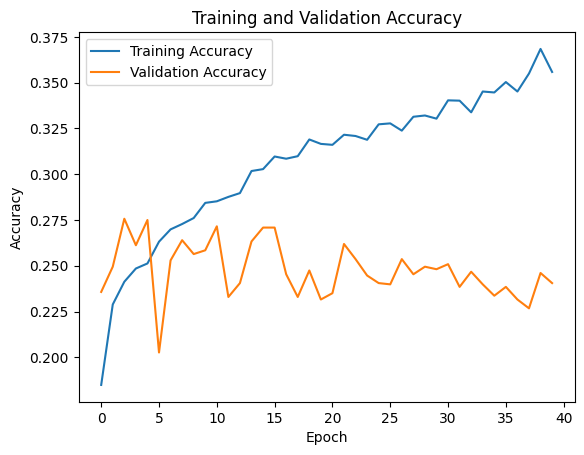

In [13]:
# CodeGrade Tag Ex4a
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation precision
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot training and validation recall
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce of the model. Be sure to demonstrate the results of the multi-label classification, comparing the top three most probable genres predicted with the ground truth genres for each poster. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

In [14]:
# CodeGrade Tag Ex4b

try:
    # Load the best weights
    status = model.load_weights(checkpoint_filepath)
    status.expect_partial()

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    # Evaluate the model on the test dataset
    evaluation_results = model.evaluate(test_dataset)

    print("Evaluation Results:")
    print(f"Test Loss: {evaluation_results[0]}")
    print(f"Test Accuracy: {evaluation_results[1]}")
    print(f"Test Precision: {evaluation_results[2]}")
    print(f"Test Recall: {evaluation_results[3]}")

except Exception as e:
    print("An error occurred during model evaluation:")
    print(e)



# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Extract ground truth labels from the test dataset
ground_truth_labels = labels_test

# Function to get top n predicted genres
def get_top_predicted_genres(prediction, genres, n=3):
    top_indices = prediction.argsort()[-n:][::-1]
    top_genres = [genres[i] for i in top_indices]
    return top_genres

# Function to get top n ground truth genres
def get_top_ground_truth_genres(label, genres, n=3):
    top_indices = label.argsort()[-n:][::-1]
    top_genres = [genres[i] for i in top_indices]
    return top_genres

# Compare predicted genres with ground truth genres for each poster
predicted_genres_top3 = []
ground_truth_genres_top3 = []

for i in range(len(predictions)):
    predicted_top3 = get_top_predicted_genres(predictions[i], genres, n=3)
    ground_truth_top3 = get_top_ground_truth_genres(ground_truth_labels[i],
                                                    genres, n=3)
    predicted_genres_top3.append(predicted_top3)
    ground_truth_genres_top3.append(ground_truth_top3)

# Plot classification performance
# You can create plots comparing the predicted genres with the ground truth genres here
# For example, you can create a bar chart or a confusion matrix to visualize the performance

23/23 [==============================] - 1s 11ms/step - loss: 0.2759 - accuracy: 0.2385 - precision_1: 0.5751 - recall_1: 0.2015
Evaluation Results:
Test Loss: 0.275860995054245
Test Accuracy: 0.23845623433589935
Test Precision: 0.5751252174377441
Test Recall: 0.2015209197998047
23/23 [==============================] - 0s 7ms/step


In [15]:
# Load movie names from the test dataset
movie_names = data_test['Id'].values

# Create a DataFrame with movie names, predicted genres, and actual genres
df = pd.DataFrame({
    'Movie Code': movie_names,
    'Predicted Genres': [' / '.join(row) for row in predicted_genres_top3],
    'Actual Genres': [' / '.join(row) for row in ground_truth_genres_top3]
})

# Display the DataFrame
df.head()

,Movie Code,Predicted Genres,Actual Genres
0,tt0087363,Drama / Documentary / Comedy,Fantasy / Horror / Comedy
1,tt0479647,Drama / Action / Comedy,Crime / Action / Comedy
2,tt0120363,Drama / Action / Thriller,Animation / Adventure / Comedy
3,tt1661382,Action / Drama / Adventure,Sport / Comedy / Western
4,tt1197628,Drama / Comedy / Romance,Crime / Comedy / Drama


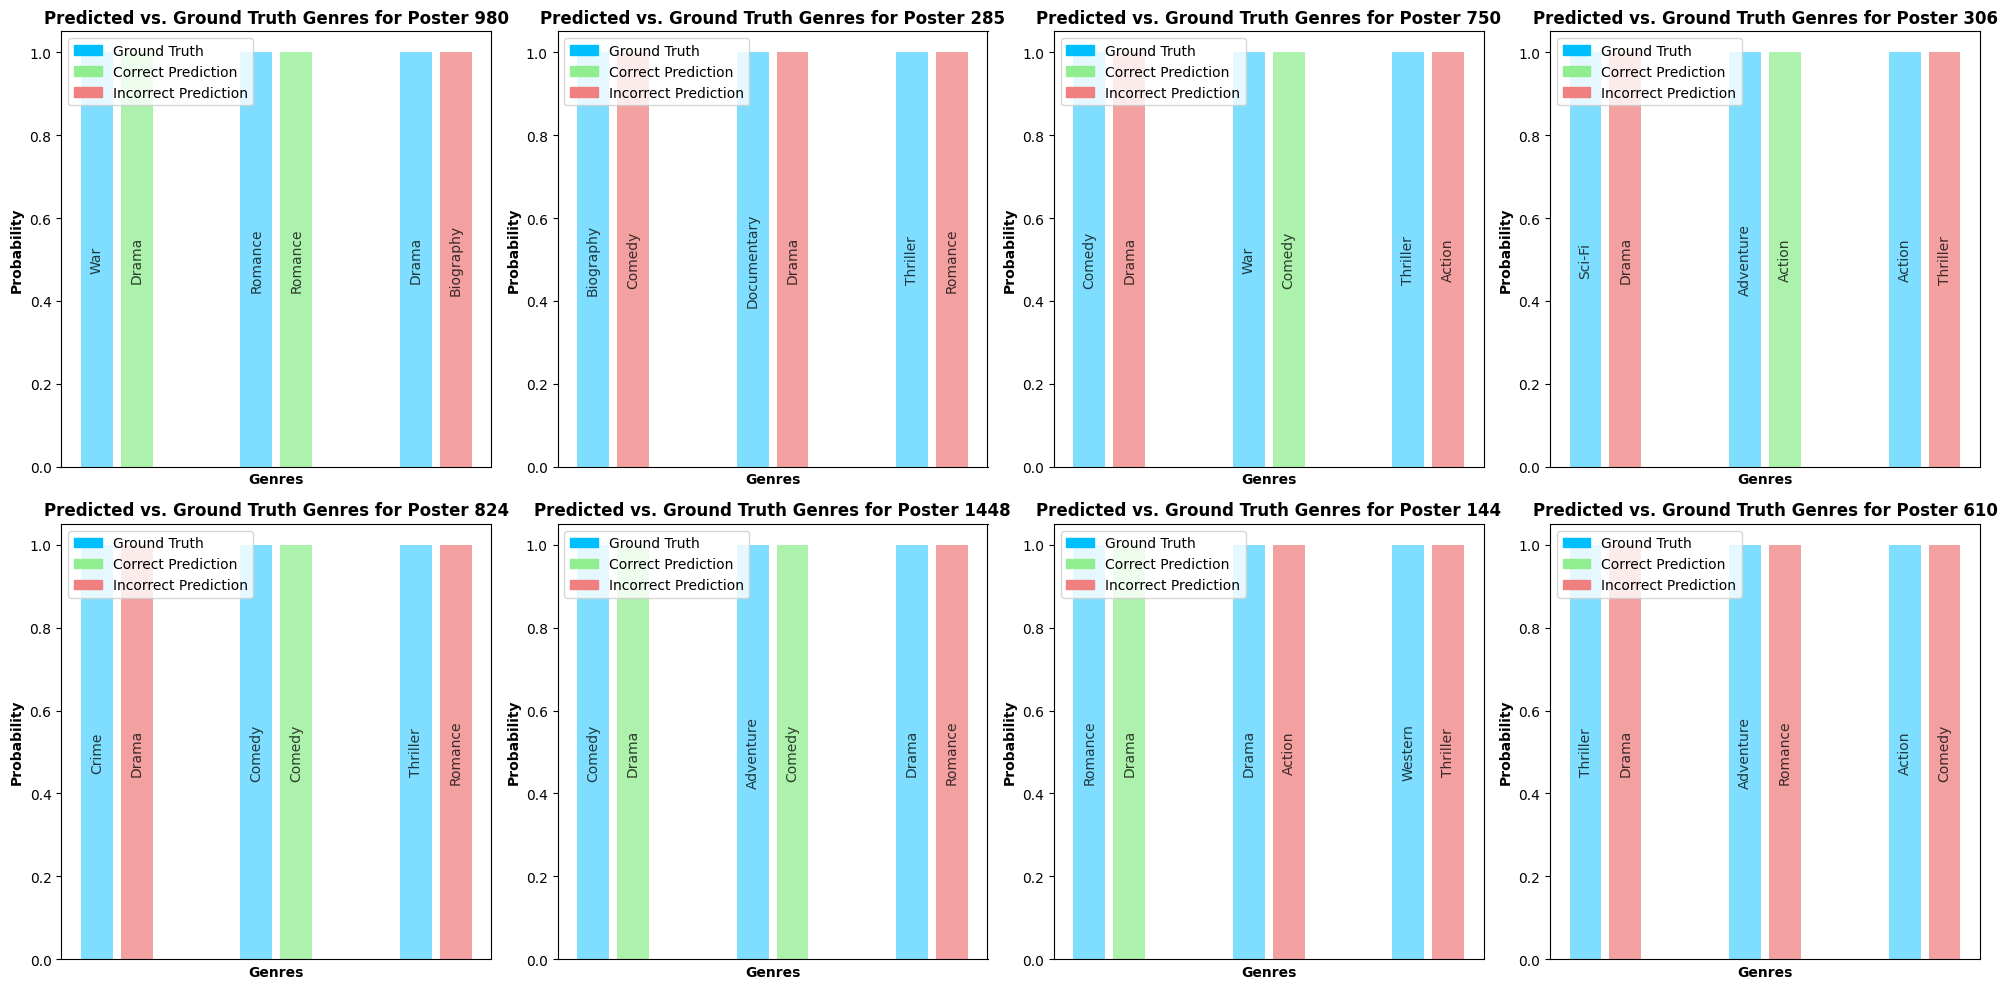

In [16]:
# Convert predicted and ground truth genres to numpy arrays
predicted_genres_top3 = np.array(predicted_genres_top3)
ground_truth_genres_top3 = np.array(ground_truth_genres_top3)

# Plot bar chart for a random sample of posters
num_posters_to_plot = 8
random_indices = np.random.choice(len(predictions), num_posters_to_plot,
                                  replace=False)

# Create subplots with 4 columns and 2 rows
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Iterate through random indices and plot each poster
for i, idx in enumerate(random_indices):
    # Calculate subplot coordinates
    row = i // 4
    col = i % 4
    bar_width = 0.2
    index = np.arange(3)
    opacity = 0.75

    # Get the current axis
    ax = axs[row, col]

    # Plot ground truth
    for j, genre in enumerate(ground_truth_genres_top3[idx]):
        ground_truth_bar = ax.bar(index[j] - bar_width - 0.05, 1, bar_width,
                                  alpha=0.5, color='deepskyblue')
        ax.text(index[j] - bar_width/2 - 0.15, 0.5, genre, color='black',
                ha='center', va='center', rotation=90, alpha=opacity)

    # Plot predicted
    for j, genre in enumerate(predicted_genres_top3[idx]):
        if genre in ground_truth_genres_top3[idx]:
            color = 'lightgreen'  # Predicted genre matches ground truth
        else:
            color = 'lightcoral'  # Predicted genre does not match ground truth
        predicted_bar = ax.bar(index[j], 1, bar_width, alpha=opacity,
                               color=color)
        ax.text(index[j], 0.5, genre, color='black', ha='center',
                va='center', rotation=90, alpha=opacity)

    ax.set_xticks([])
    ax.set_ylabel('Probability', fontweight='semibold')
    ax.set_xlabel('Genres', fontweight='semibold')
    ax.set_title('Predicted vs. Ground Truth Genres for Poster {}'.format(idx),
                 fontweight='bold')

    # Add legends
    legend_elements = [mpatches.Patch(color='deepskyblue',
                                      label='Ground Truth'),
                           mpatches.Patch(color='lightgreen',
                                          label='Correct Prediction'),
                           mpatches.Patch(color='lightcoral',
                                          label='Incorrect Prediction')]
    ax.legend(handles=legend_elements, loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

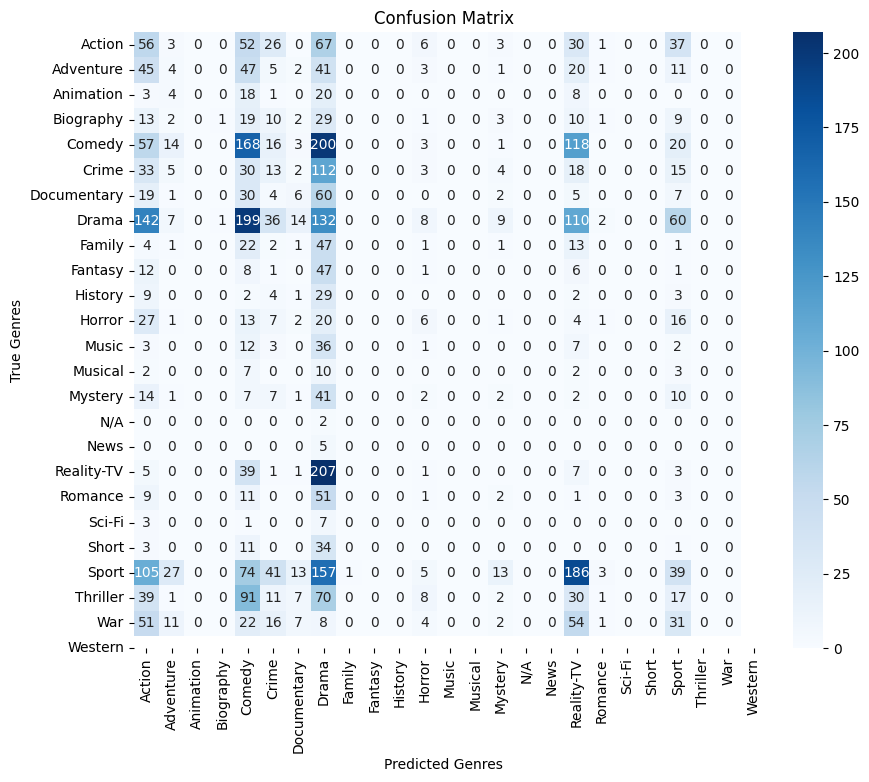

In [17]:
# Create confusion matrix
conf_matrix = confusion_matrix(ground_truth_genres_top3.ravel(),
                               predicted_genres_top3.ravel())

# Heatmap for Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=genres, yticklabels=genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genres')
plt.ylabel('True Genres')
plt.show()

In [18]:
# Generate classification report
classification_rep = classification_report(ground_truth_genres_top3.ravel(),
                                           predicted_genres_top3.ravel(),
                                           zero_division=1)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

      Action       0.09      0.20      0.12       281
   Adventure       0.05      0.02      0.03       180
   Animation       1.00      0.00      0.00        54
   Biography       0.50      0.01      0.02       100
      Comedy       0.19      0.28      0.23       600
       Crime       0.06      0.06      0.06       235
 Documentary       0.10      0.04      0.06       134
       Drama       0.09      0.18      0.12       720
      Family       0.00      0.00      0.00        93
     Fantasy       1.00      0.00      0.00        76
     History       1.00      0.00      0.00        50
      Horror       0.11      0.06      0.08        98
       Music       1.00      0.00      0.00        64
     Musical       1.00      0.00      0.00        24
     Mystery       0.04      0.02      0.03        87
         N/A       1.00      0.00      0.00         2
        News       1.00      0.00      0.00         5
    

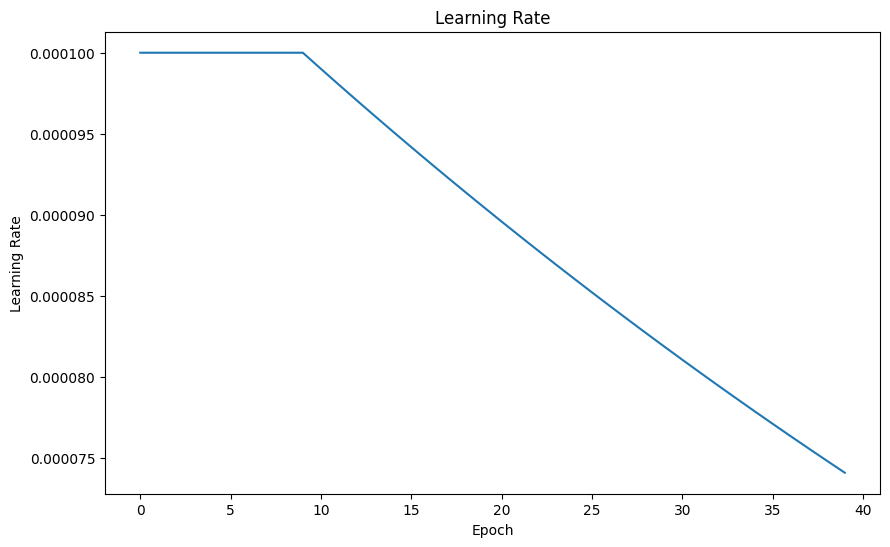

In [19]:
# Plot learning rate
plt.figure(figsize=(10, 6))
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


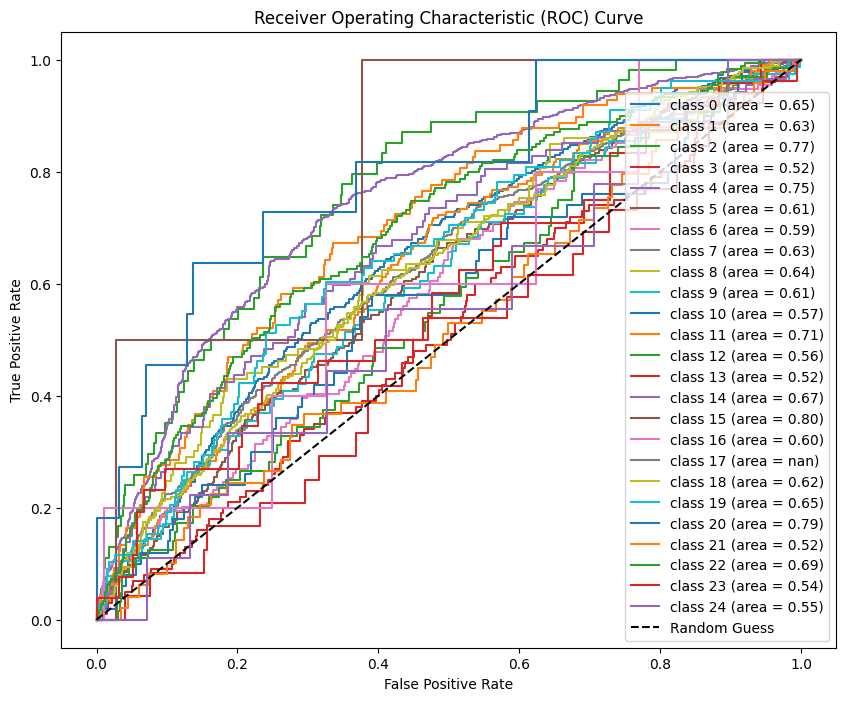

In [20]:
from sklearn.metrics import roc_curve, auc

# Determine the number of classes from the shape of labels_test
num_classes = labels_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i],
             label='class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

